In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [6]:
portfolio=[]
Cevap=input("Lütfen bir hisse Giriniz:")
portfolio.append(Cevap)
if len(portfolio)>0:
  print("Hisseniz işleme hazırdır.")

Lütfen bir hisse Giriniz:AAPL
Hisseniz işleme hazırdır.


In [3]:
def buy_sell_MA(data, opt=50):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42

    up = data[(np.array(data["short"] - data["mid"]) > 0) & (np.array(data["short"] - data["long"]) > 0)]
    down = data[(np.array(data["short"] - data["mid"]) < 0) & (np.array(data["short"] - data["long"]) < 0)]

    if len(up) > 0:
        ups = np.percentile(np.array(up["short"] - up["mid"]), opt)
    else:
        ups = 0

    if len(down) > 0:
        downs = np.percentile(np.array(down["short"] - down["long"]), opt)
    else:
        downs = 0

    for i in range(0, len(data)):
        if (data["short"][i] > data["mid"][i] + ups) & (data["short"][i] > data["long"][i] + ups):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i] < data["mid"][i] + downs) & (data["short"][i] < data["long"][i] + downs):
            sell_signal.append(np.nan)
            if flag != 0:
              buy_signal.append(data["Close"][i])
              buy_sell.append(-data["Close"][i])
              flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations = np.array(buy_sell)
    operations = operations[~np.isnan(operations)]

    neg = 0
    pos = 0

    for i in range(len(operations)):
        if operations[i] < 0:
            neg = i
            break
    for i in range(1, len(operations)):
        if operations[-i] > 0:
            pos = i - 1
            break

    PL = np.sum(operations)

    return (buy_signal, sell_signal, PL)

In [5]:
def stock(ticker):
    data = yf.download(ticker, start="2022-06-01", end=datetime.date.today())
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    close = pd.DataFrame(data["Close"])
    rolling_app5 = close.ewm(com=0.75).mean()
    rolling_app8 = close.ewm(com=9/11).mean()
    rolling_app13 = close.ewm(com=0.875).mean()
    MAs = pd.concat([close, rolling_app5, rolling_app8, rolling_app13], axis=1)
    MAs.columns = ["Close", "short", "mid", "long"]
    MAs = MAs.dropna(axis=0)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(close.index, close, label=ticker)
    ax.plot(rolling_app5.index, rolling_app5, label=ticker+' 5 Günlük Ortalama')
    ax.plot(rolling_app8.index, rolling_app8, label=ticker+' 8 Günlük Ortalama')
    ax.plot(rolling_app13.index, rolling_app13, label=ticker+' 13 Günlük Ortalama')


    ax.legend(loc='upper left')

    def kar(percentile):
        MAs["Buy"] = buy_sell_MA(MAs, percentile)[0]
        MAs["Sell"] = buy_sell_MA(MAs, percentile)[1]
        al = MAs["Buy"]
        al = al.dropna(axis=0)
        sat = MAs["Sell"]
        sat = sat.dropna(axis=0)
        sat_val = sat.values
        al_val = al.values
        res = []
        if len(al_val) == len(sat_val):
            for i in range(len(al_val)):
                res.append(sat_val[i]/al_val[i])
        elif len(al_val) > len(sat_val):
            al_val = np.delete(al_val, -1)
            for j in range(len(sat_val)):
                res.append(sat_val[j]/al_val[j])
        elif len(sat_val) > len(al_val):
            sat_val = np.delete(sat_val, 0)
            for k in range(len(al_val)):
                res.append(sat_val[k]/al_val[k])

        df = pd.DataFrame()
        df["Kar"] = res

        return np.prod(df["Kar"])

    MAs["Buy"] = buy_sell_MA(MAs, 50)[0]
    MAs["Sell"] = buy_sell_MA(MAs, 50)[1]
    al = MAs["Buy"]
    al = al.dropna(axis=0)
    sat = MAs["Sell"]
    sat = sat.dropna(axis=0)
    sat_val = sat.values
    al_val = al.values
    percentile = range(1, 100)
    kardf = pd.DataFrame()
    kardf["Percentile"] = percentile
    for i in range(len(percentile)):
        kardf.loc[i, 1] = kar(percentile[i])
    kardf.columns = ["Percentile", "Performance"]
    kardf = kardf.sort_values(by="Performance", ascending=False)
    MAs["Buy"] = buy_sell_MA(MAs, kardf["Percentile"].values[0])[0]
    MAs["Sell"] = buy_sell_MA(MAs, kardf["Percentile"].values[0])[1]
    plt.figure(figsize=(12, 5))
    plt.scatter(MAs.index, MAs["Buy"], color="green", label='Al', marker='^', alpha=1)
    plt.scatter(MAs.index, MAs["Sell"], color="red", label='Sat', marker='v', alpha=1)
    plt.plot(MAs["Close"], label='Kapanış Fiyatı', alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend(loc='upper left')
    plt.show()
    al = MAs["Buy"]
    al = al.dropna(axis=0)
    sat = MAs["Sell"]
    sat = sat.dropna(axis=0)
    sat_val = sat.values
    al_val = al.values
    res1 = []

    if len(al_val) == len(sat_val):
        for i in range(len(al_val)):
            res1.append(sat_val[i]/al_val[i])
    elif len(al_val) > len(sat_val):
        al_val = np.delete(al_val, -1)
        for j in range(len(sat_val)):
            res1.append(sat_val[j]/al_val[j])
    elif len(sat_val) > len(al_val):
        sat_val = np.delete(sat_val, 0)
        for k in range(len(al_val)):
            res1.append(sat_val[k]/al_val[k])


    df1 = pd.DataFrame()
    df1["Kar"]=res1

    res2 = [100]
    for i in range(len(df1.index)):
        res2.append(res2[i]*df1["Kar"].loc[i])

    df1["Eldeki Para"] = res2[1:]

    if len(df1["Eldeki Para"]) == 0:
        print("Eldeki Para hesaplaması yapılamadı. Veri yetersiz.")
        return

    karlilik = df1["Eldeki Para"].iloc[-1] / 100
    karlilik = (karlilik - 1) * 100
    print("Karlılık oranı %", karlilik)

[*********************100%%**********************]  1 of 1 completed


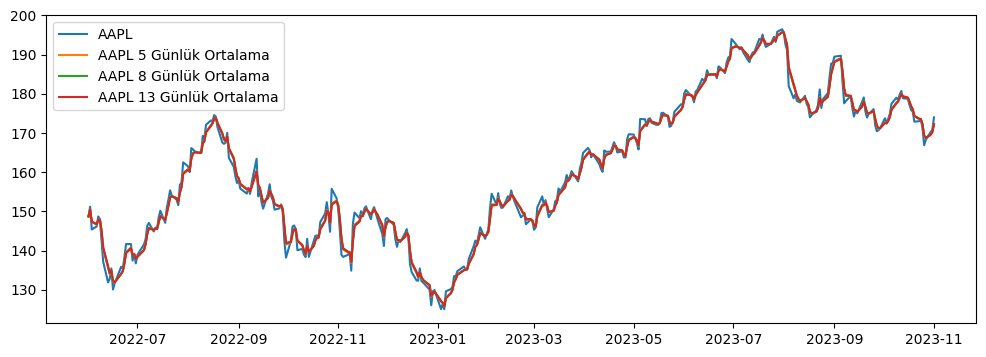

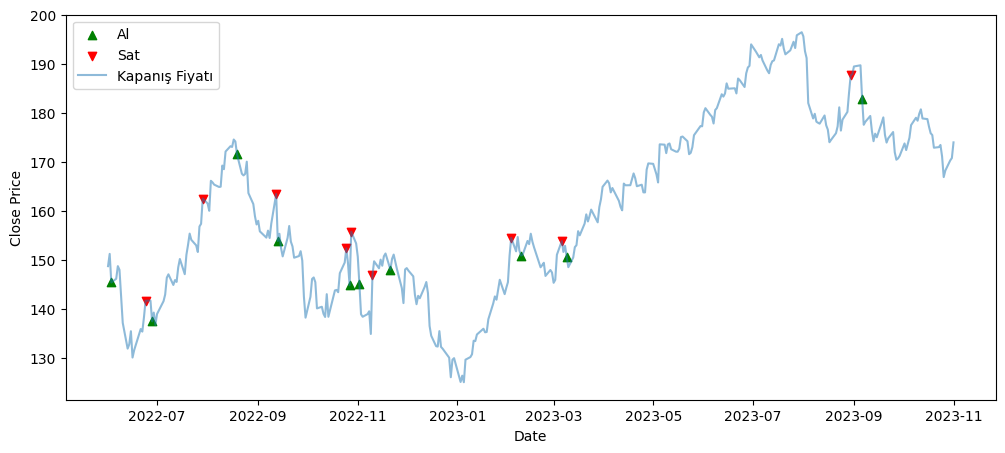

Karlılık oranı % 57.038467051325604


In [7]:
for i in portfolio:
  stock(i)